In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from dateutil import parser

In [55]:
data = pd.read_csv('ncaa_data.csv')
data.head()

,Year,Round,Region Number,Region Name,seed_1,score_1,team_1,team_2,score_2,seed_2,winning_seed
0,1985,1,1,West,1,83,St Johns,Southern,59,16,NaN
1,1985,1,1,West,2,81,VCU,Marshall,65,15,NaN
2,1985,1,1,West,3,65,NC State,Nevada,56,14,NaN
3,1985,1,1,West,4,85,UNLV,San Diego St,80,13,NaN
4,1985,1,1,West,5,58,Washington,Kentucky,65,12,NaN


Let's create a column for "winning seed" so we can examine the distribution 
of winners per round

In [57]:
data['winning_seed'] = np.where(data['score_1']>=data['score_2'], data['seed_1'], data['seed_2'])
data.head()

,Year,Round,Region Number,Region Name,seed_1,score_1,team_1,team_2,score_2,seed_2,winning_seed
0,1985,1,1,West,1,83,St Johns,Southern,59,16,1
1,1985,1,1,West,2,81,VCU,Marshall,65,15,2
2,1985,1,1,West,3,65,NC State,Nevada,56,14,3
3,1985,1,1,West,4,85,UNLV,San Diego St,80,13,4
4,1985,1,1,West,5,58,Washington,Kentucky,65,12,12


Let's also create an 'upset' column to tell us whether or not a given game
went "as expected"

In [77]:
data['favorite'] = np.where(data['seed_1']<data['seed_2'], data['seed_1'], data['seed_2'])
# account for cases where there is no favorite (ie identical seeds)
data['favorite'] = np.where(data['seed_1'] == data['seed_2'], -1, data['favorite'])
data['upset'] = np.where(data['winning_seed'] != data['favorite'], 1, 0)
# force games showcasing tied seeds to be '0' in the 'upset' column
data['upset'] = np.where(data['favorite'] == -1, 0, data['upset'])
data.head()

,Year,Round,Region Number,Region Name,seed_1,score_1,team_1,team_2,score_2,seed_2,winning_seed,favorite,upset
0,1985,1,1,West,1,83,St Johns,Southern,59,16,1,1,0
1,1985,1,1,West,2,81,VCU,Marshall,65,15,2,2,0
2,1985,1,1,West,3,65,NC State,Nevada,56,14,3,3,0
3,1985,1,1,West,4,85,UNLV,San Diego St,80,13,4,4,0
4,1985,1,1,West,5,58,Washington,Kentucky,65,12,12,5,1


How common are upsets at different stages of the tournament?

In [87]:
data.query('Year >= 2003')[['upset', 'Round']].groupby(['Round']).agg('sum')

,upset
Round,
1,130
2,74
3,37
4,33
5,6
6,3


Can we get an upset percentage by dividing total upsets by _potential_ upsets in each round?

In [99]:
data.query('Year >= 2003')[['upset', 'Round']].groupby(['Round']).agg('count')

,upset
Round,
1,512
2,256
3,128
4,64
5,32
6,16


Careful, we only want to count games where an upset was _possible_. So we'll exclude all rows where favorite = -1 (meaning
the game show cased two teams of the same seed, there was no seed-favorite)

It looks like there have been 5 finals since 2003 showcasing tied seeds, and 12 final fours showcasing tied seeds. We'll want to
exclude these from our 'upset percentage' analysis, since including them would conflate our results

In [90]:
data.query('Year >= 2003 & favorite != -1')[['upset', 'Round']].groupby(['Round']).agg('count')

,upset
Round,
1,512
2,256
3,128
4,64
5,24
6,11


In [100]:
# Since 2003
all_potentially_upset_games = data.query('Year >= 2003 & favorite != -1')[['upset', 'Round']].groupby(['Round']).agg('count')
all_upsets = data.query('Year >= 2003')[['upset', 'Round']].groupby(['Round']).agg('sum')

In [101]:
pd.concat([all_potentially_upset_games, all_upsets], axis=1, ignore_index=True)

,0,1
Round,,
1,512,130
2,256,74
3,128,37
4,64,33
5,24,6
6,11,3


In [114]:
upset_pct = pd.concat([all_potentially_upset_games, all_upsets], axis=1, ignore_index=True)
upset_pct.reset_index().columns

Index(['Round', 0, 1], dtype='object')

In [122]:
upset_pct = upset_pct.rename(columns = {0: "upset_candidates", 
                                  1:"actual_upsets" 
                                  }) 

In [123]:
upset_pct['upset_pct'] = upset_pct['actual_upsets']/upset_pct['upset_candidates']

In [124]:
upset_pct

,upset_candidates,actual_upsets,upset_pct
Round,,,
1,512,130,0.253906
2,256,74,0.289062
3,128,37,0.289062
4,64,33,0.515625
5,24,6,0.250000
6,11,3,0.272727


Shockingly, upsets are pretty constant throughout the tournament, hovering around the 25% mark. But in the elite 8 that stat
essentially doubles to 50% ! So to make a better bracket, don't be afraid to call an upset in the elite eight

(array([776., 249., 362., 147., 224.,  80., 169.,  68.,  57.,  10.]),
 array([ 1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. , 11.5, 13. , 14.5, 16. ]),
 <a list of 10 Patch objects>)

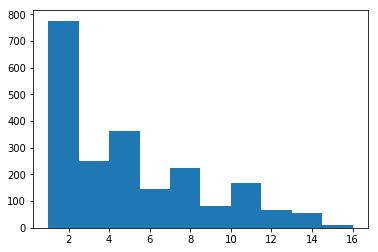

In [125]:
plt.hist(data['winning_seed'])

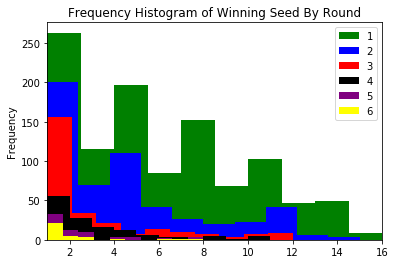

In [144]:
x1 = data.loc[data.Round==1, 'winning_seed']
x2 = data.loc[data.Round==2, 'winning_seed']
x3 = data.loc[data.Round==3, 'winning_seed']
x4 = data.loc[data.Round==4, 'winning_seed']
x5 = data.loc[data.Round==5, 'winning_seed']
x6 = data.loc[data.Round==6, 'winning_seed']

#kwargs = dict(alpha=0.5, bins=100)

plt.hist(x1, color='green', label='1')
plt.hist(x2, color='blue', label='2')
plt.hist(x3, color='red', label='3')
plt.hist(x4, color='black', label='4')
plt.hist(x5, color='purple', label='5')
plt.hist(x6, color='yellow', label='6')
plt.gca().set(title='Frequency Histogram of Winning Seed By Round', ylabel='Frequency')
plt.xlim(1,16)
plt.legend();

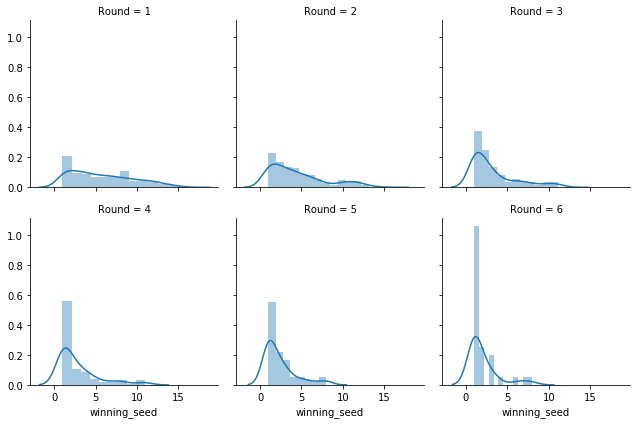

In [150]:
g = sn.FacetGrid(data, col="Round", col_wrap = 3)
g.map(sn.distplot, "winning_seed");